## 1. Notebook for Principal Component Analysis

In [2]:
# Standard imports
import os
import cv2
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
%matplotlib inline

## 2. Finding the SVD using numpy
The following code blocks demonstrate how to use numpy to find the singular values and vectors of a matrix.

In [4]:
# Demo SVD for small matrix
A = np.random.randn(4,3)
A

array([[-0.13755635, -0.8736779 , -0.56518156],
       [-0.3911768 , -0.69924005, -0.30923493],
       [ 0.79637098, -1.17934361, -1.04135591],
       [ 0.88186784, -1.02098563, -1.43681283]])

In [5]:
[U,S,VT] = la.svd(A, full_matrices=False)

In [6]:
U

array([[ 0.32108376, -0.57598357,  0.06551194],
       [ 0.18803332, -0.72874096,  0.10404757],
       [ 0.62173652,  0.13593929, -0.76546035],
       [ 0.68919692,  0.34452872,  0.63162706]])

In [7]:
S

array([2.81306931, 0.92780766, 0.24305377])

In [8]:
Sigma = np.diag(S)
Sigma

array([[2.81306931, 0.        , 0.        ],
       [0.        , 0.92780766, 0.        ],
       [0.        , 0.        , 0.24305377]])

In [9]:
VT.T

array([[ 0.35021964,  0.83679376, -0.42085912],
       [-0.65725553,  0.5396711 ,  0.52608961],
       [-0.66735401, -0.09236507, -0.73899075]])

Let's check that $A = U\Sigma V^{\top}$:

In [11]:
reconstruct_A = U@np.diag(S)@VT
reconstruct_A 

array([[-0.13755635, -0.8736779 , -0.56518156],
       [-0.3911768 , -0.69924005, -0.30923493],
       [ 0.79637098, -1.17934361, -1.04135591],
       [ 0.88186784, -1.02098563, -1.43681283]])

In [12]:
A

array([[-0.13755635, -0.8736779 , -0.56518156],
       [-0.3911768 , -0.69924005, -0.30923493],
       [ 0.79637098, -1.17934361, -1.04135591],
       [ 0.88186784, -1.02098563, -1.43681283]])

## 3. First Singular vector as line of best fit
Let's generate some example data in two dimensions (so that we can see it) and then examine the first right singular vector of this data. As we'll see when discussing PCA, this vector gives the direction of the line of best fit for the data.

(1000, 2)


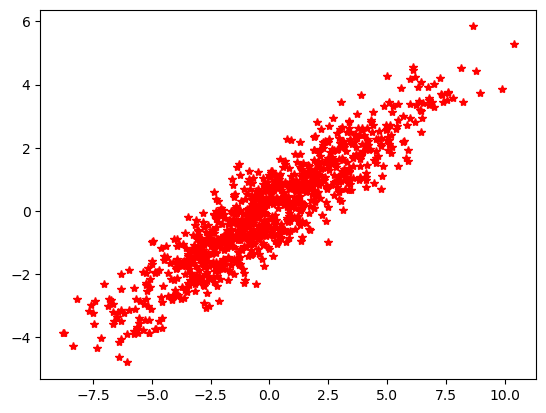

In [14]:
# Generate data points in 2D plane
fig = plt.figure()
Covariance_Matrix = np.array([[10,5],[5,3]])
center = [0,0]
Data = npr.multivariate_normal(center,Covariance_Matrix,1000)
plt.plot(Data[:,0],Data[:,1],'r*')
print(Data.shape)
plt.show()

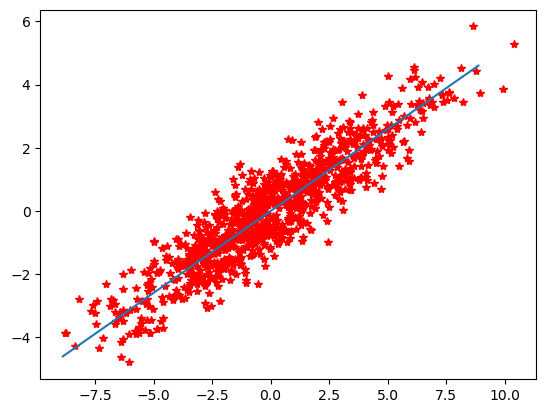

In [15]:
## Now let's find the leading singular vector
[U,S,VT] = la.svd(Data, full_matrices=False)
v1 = VT[0,:].T
Line_of_best_fit = np.zeros([10000,2])
i = 0
# now plot line {tv_1 : for -10< t< 10}
for t in np.linspace(-10,10,10000):
    Line_of_best_fit[i,:] = t*v1
    i +=1
plt.plot(Data[:,0],Data[:,1],'r*',Line_of_best_fit[:,0],Line_of_best_fit[:,1])
plt.show()

Note. In this example, we did not center the data before applying SVD for PCA is because it is already centered. Let's now take a look at the second singular vector for curiosity! In practice, when the data is already $d$-dimensional, we are interested in the first $k$ singular vectors $k<<d$. For data visualization, $k$=1, 2, or 3.

In [17]:
# Let's now take a look at the second singular vector.
v2 = VT[1,:].T
Line_v1 = np.zeros([10000,2])
i = 0
for t in np.linspace(-10,10,10000):
    Line_v1[i,:] = t*v1
    i +=1

Line_v2 = np.zeros([10000,2])
i = 0
for t in np.linspace(-5,5,10000):
    Line_v2[i,:] = t*v2
    i +=1
print(v2)
print(v1)
print(np.dot(v1,v2))

[-0.46027951  0.88777406]
[0.88777406 0.46027951]
-4.435623210268638e-18


Notice the sigular vectors are orthogonal, as expected.

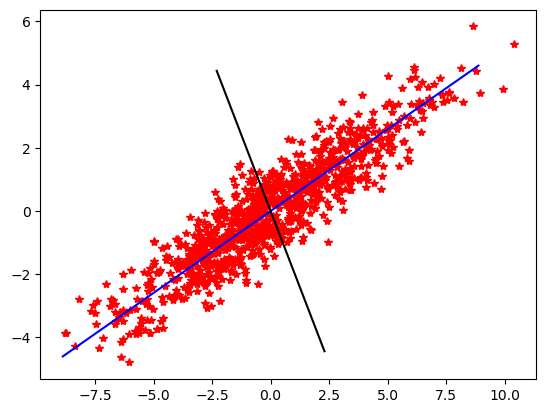

[111.91790618  19.97769082]


In [19]:
plt.plot(Data[:,0],Data[:,1],'r*', Line_v1[:,0], Line_v1[:,1], 'b', Line_v2[:,0], Line_v2[:,1],'k')
plt.show()
print(S)

In [20]:
variance = S[0]**2/np.sum(S**2)
variance

0.9691205728524486

In [21]:
print(f"The first singular vector accounts for about {variance*100:.2f}% of the variance in the data. \
It makes sense here to use $k = 1$ (i.e. reduce to one dimension).")

The first singular vector accounts for about 96.91% of the variance in the data. It makes sense here to use $k = 1$ (i.e. reduce to one dimension).


## 4. PCA on Breast Cancer Dataset

Here we will perform PCA using SVD for dimension reduction particularly for data visualization (k = 2 or 3). We'll consider the following [dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) which can also be downloaded from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

In [23]:
# Load the data
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

In [24]:
X = cancer_data.data  # Data matrix. This was A in the lecture notes
X.shape #number of samples by number of features 

(569, 30)

In [25]:
y = cancer_data.target # The data labels, either 0 or 1
y.shape

(569,)

In [26]:
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357]))

Labels --> 0: Malignant
1: Benign

Split the data into train and test (i.e. new, unseen data). Even though PCA is an unsupervised machine learning technique, the purpose of splitting the data into train and test is to show you how you could transform new, unseen data onto the low-dimensional space (e.g. what to do if you have a new patient/tumor sample). This is useful in many machine learning pipelines especially if we are performing a supervised learning task (e.g. classification) at the end.

In [29]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_new.shape)
print(y_train.shape, y_new.shape)

(455, 30) (114, 30)
(455,) (114,)


In [30]:
df_describe = pd.DataFrame(data = X_train, columns = cancer_data.feature_names)
df_describe.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   455.000000    455.000000      455.000000   455.000000   
mean     14.117635     19.185033       91.882242   654.377582   
std       3.535815      4.266005       24.322027   354.943187   
min       7.691000      9.710000       47.920000   170.400000   
25%      11.705000     16.170000       75.100000   420.300000   
50%      13.300000     18.680000       85.980000   551.700000   
75%      15.740000     21.585000      103.750000   767.600000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       455.000000        455.000000      455.000000           455.000000   
mean          0.095744          0.103619        0.088898             0.048280   
std           0.013923          0.052470        0.079468             0.038060   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.085825          0.062890        0.029320             0.020340   
50%           0.094620          0.090970        0.061540             0.033410   
75%           0.104550          0.131300        0.132350             0.073895   
max           0.163400          0.311400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst radius  \
count     455.000000              455.000000  ...    455.000000   
mean        0.181099                0.062757  ...     16.235103   
std         0.027487                0.007210  ...      4.811267   
min         0.116700                0.049960  ...      8.678000   
25%         0.161850                0.057645  ...     13.055000   
50%         0.179200                0.061480  ...     14.970000   
75%         0.195800                0.066100  ...     18.410000   
max         0.304000                0.097440  ...     36.040000   

       worst texture  worst perimeter   worst area  worst smoothness  \
count     455.000000       455.000000   455.000000        455.000000   
mean       25.535692       107.103121   876.987033          0.131532   
std         6.065108        33.374664   567.672841          0.023083   
min        12.020000        54.490000   223.600000          0.071170   
25%        21.045000        84.255000   516.450000          0.114400   
50%        25.220000        97.670000   686.600000          0.130900   
75%        29.690000       124.650000  1031.500000          0.146050   
max        49.540000       251.200000  4254.000000          0.218400   

       worst compactness  worst concavity  worst concave points  \
count         455.000000       455.000000            455.000000   
mean            0.252742         0.274595              0.114182   
std             0.155014         0.209398              0.065326   
min             0.027290         0.000000              0.000000   
25%             0.144950         0.116550              0.063930   
50%             0.210100         0.226400              0.098610   
75%             0.341600         0.387200              0.161100   
max             0.937900         1.252000              0.291000   

       worst symmetry  worst fractal dimension  
count      455.000000               455.000000  
mean         0.290502                 0.083868  
std          0.063151                 0.017848  
min          0.156500                 0.055040  
25%          0.249500                 0.071050  
50%          0.282700                 0.080060  
75%          0.317750                 0.092070  
max          0.663800                 0.173000  

[8 rows x 30 columns]

The features have drastically varying ranges. We will need to normalize the data before applying PCA.

In [32]:
# Check for missing data and data type
df_describe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              455 non-null    float64
 1   mean texture             455 non-null    float64
 2   mean perimeter           455 non-null    float64
 3   mean area                455 non-null    float64
 4   mean smoothness          455 non-null    float64
 5   mean compactness         455 non-null    float64
 6   mean concavity           455 non-null    float64
 7   mean concave points      455 non-null    float64
 8   mean symmetry            455 non-null    float64
 9   mean fractal dimension   455 non-null    float64
 10  radius error             455 non-null    float64
 11  texture error            455 non-null    float64
 12  perimeter error          455 non-null    float64
 13  area error               455 non-null    float64
 14  smoothness error         4

No missing data for this dataset. There are ways to "handle" missing data (which is very common in real data).

In [34]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [35]:
# Center the data for PCA
mu = np.mean(X_train,axis = 0, keepdims = True)
X_train_tilde = X_train - mu
X_train_tilde.shape

(455, 30)

In [36]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

In [37]:
# X_2D = U[:,0:2]@np.diag(S[0:2]) # or equivalently:
X_2D = np.dot(X_train_tilde,VT[0:2,:].T)
X_2D.shape 

(455, 2)

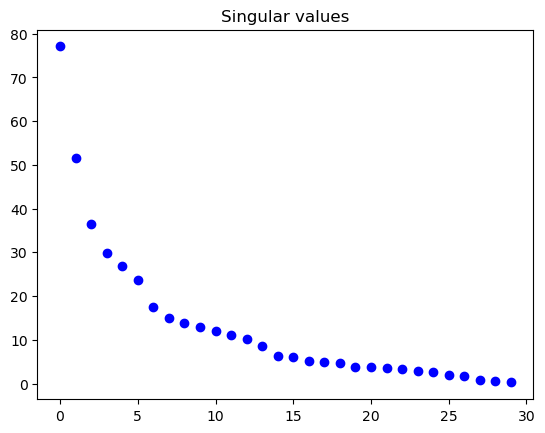

In [38]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

In [39]:
variance = (S[0]**2+S[1]**2)/np.sum(S**2)
variance

0.6300278846854037

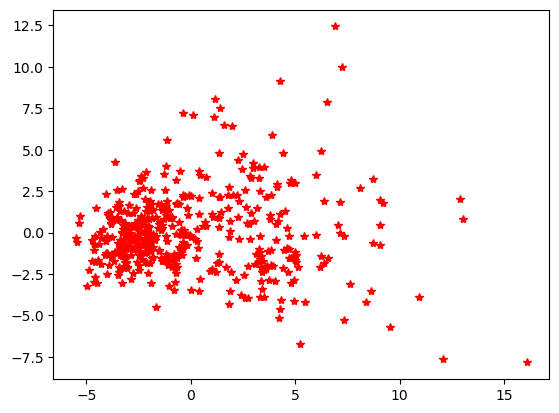

In [40]:
fig = plt.figure()
plt.plot(X_2D[:,0],X_2D[:,1],'*r')
plt.show()

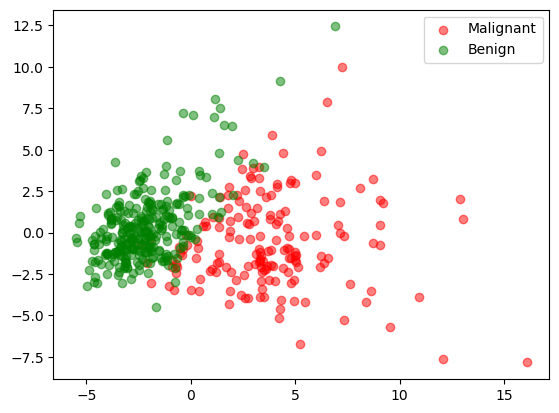

In [41]:
fig = plt.figure()
colors = ['red', 'green']
labels = ["Malignant", "Benign"]
for i in range(0,2):
    plt.scatter(X_2D[:,0][y_train == i],X_2D[:,1][y_train == i], color = colors[i], alpha=0.5, label= labels[i])
plt.legend()
plt.show()

In the above plot, it's clearer that there are two classes. If you were looking at classifying these masses, PCA finds a "good" representation of the data in which we can still discriminate between the classes.

In [43]:
X_3D = X_train_tilde@VT[0:3,:].T
X_3D.shape

(455, 3)

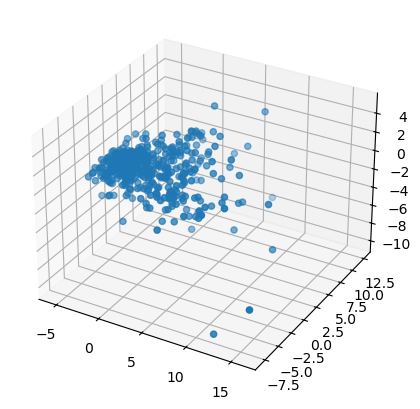

In [44]:
#%matplotlib notebook
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2])
plt.show()

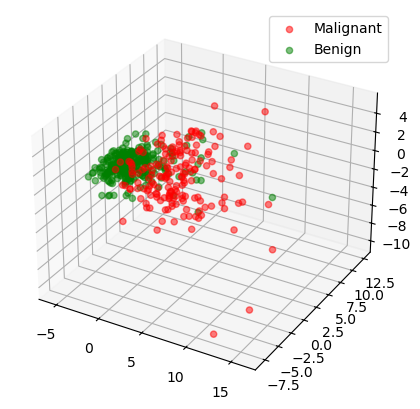

In [45]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green']
labels = ["Malignant", "Benign"]

for i in range(0,2):
    ax.scatter(X_3D[:,0][y_train == i],X_3D[:,1][y_train == i],X_3D[:,2][y_train == i],
                color = colors[i], alpha=0.5, label= labels[i])
plt.legend()
plt.show()

In [46]:
variance = (S[0]**2+S[1]**2+S[2]**2)/np.sum(S**2)
variance

0.7278430734090063

#### Supoose you now new unseen data. What do we do?

In [48]:
# Standarize the features
X_new = scaler.transform(X_new) # Notice we don't fit the transformer to the test data we only transform

In [49]:
# Center the data for PCA
X_new_tilde = X_new - mu
X_new_tilde.shape

(114, 30)

In [50]:
# Apply learnt PCA model (i.e. the linear transformation that maps the data from high to low-dimensional space)
X_new_2D = X_new_tilde@VT[0:2,:].T
X_new_2D

array([[-0.73876965,  0.64390571],
       [ 2.68151063, -4.41052393],
       [ 1.47649913, -1.07657525],
       [-0.87827791,  2.44052157],
       [-1.64043261,  2.37170712],
       [10.41582596,  1.57232789],
       [ 7.22413641, -3.70150702],
       [ 1.7094618 , -1.55324285],
       [ 1.22857887,  2.46080548],
       [-3.15942918, -2.00743045],
       [-2.76564229, -1.58815694],
       [ 1.21699712, -2.01744497],
       [-2.97443896, -2.66640876],
       [ 2.13809077,  1.03580227],
       [-3.11130014, -0.84613054],
       [ 5.05390324,  0.71184009],
       [-2.75129015, -2.12242015],
       [-3.80124615,  1.09935437],
       [-4.45410377,  3.45191104],
       [ 5.18120104, -2.43069395],
       [-0.32224119,  0.11959399],
       [-1.94045928,  0.42116677],
       [ 7.71249762, -0.96815067],
       [-4.66016561, -0.34527735],
       [-3.031957  , -0.22904042],
       [-0.75620863,  1.81530529],
       [-2.28795054, -0.8891064 ],
       [-2.01796549,  1.69263903],
       [-2.35345791,

We can repeat the above experiments with sklearn built-in PCA function ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

## 5. SVD for Image Compression
The AT&T face dataset, “(formerly ‘The ORL Database of Faces’), contains a set of face images taken between April 1992 and April 1994 at the lab. The database was used in the context of a face recognition project carried out in collaboration with the Speech, Vision and Robotics Group of the Cambridge University Engineering Department.”
Note. The dataset is already preprocessed (i.e. the images are centered, of all same dimensions, ...) which typically needs to be done for most real data.

In [53]:
# Input paths
BASE = 'att-database-of-faces/'

In [54]:
fig = plt.figure()
img = cv2.imread(BASE + 's1/1.pgm', 0) # '0' for reading grayscale images
img

array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8)

<Figure size 640x480 with 0 Axes>

In [55]:
img = img/255 # convert to (0,1) range

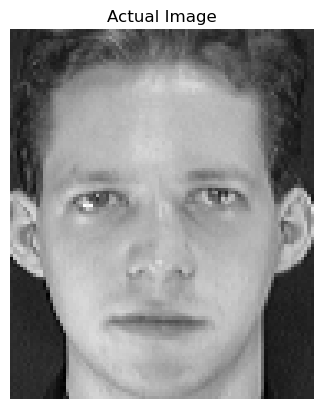

(112, 92)


In [56]:
IMG_SHAPE = img.shape
plt.imshow(img, cmap='gray')
plt.title("Actual Image")
plt.axis('off')
plt.show()

print(IMG_SHAPE)

In [57]:
112*92

10304

In [58]:
U,S,VT = np.linalg.svd(img)

In [59]:
k=15

# Choosing the first k columns of VT
V_reduced = VT[0:k,:].T

# Choosing the first k columns of U
U_reduced = U[:, 0:k]

# Choosing the k largest singular values
S_reduced = np.diag(S[0:k])

# Computing the k basis image vectors 
Z = S_reduced@V_reduced.T

In [60]:
A_0 = np.dot(U_reduced, Z)

<function matplotlib.pyplot.show(close=None, block=None)>

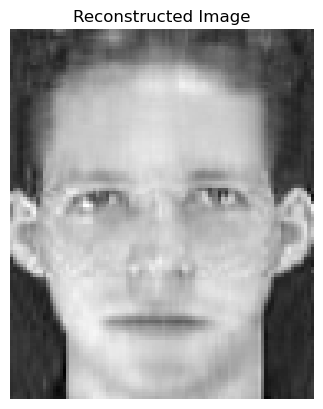

In [61]:
plt.imshow(A_0, cmap = 'gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show

In [62]:
15*112 + 15*92 + 15

3075

What this means is that instead of storing all $112\times92 = 10304$ pixel values, we can instead store the first $15$ left singular vectors, the first $15$ right singular vectors and the first $15$ singular values. Thus, we need only store $15\times 112 + 15\times 92 + 15 = 3075$ numbers.

## 6. SVD: Eigenfaces

We also consider here the AT&T face dataset.

In [65]:
# Input Paths
BASE = 'att-database-of-faces/'

In [66]:
fig = plt.figure()
img = cv2.imread(BASE + 's1/1.pgm', 0) # '0' for reading grayscale images
img

array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8)

<Figure size 640x480 with 0 Axes>

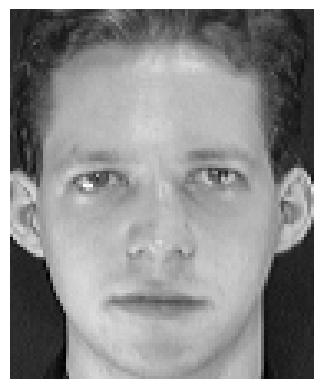

(112, 92)


In [67]:
img = img/255

IMG_SHAPE = img.shape
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(IMG_SHAPE)

In [68]:
# Creating a dataframe
filepaths = [] # Contains the absolute paths of all the image files
for s_i in os.listdir(BASE): # The folders containing the files are labelled as s1, s2, etc
    if s_i != 'README': # There is also a README file present in the data, this must be ignored
        for filename in os.listdir(BASE + s_i):
            filepaths.append(BASE + s_i + '/' + filename)

In [69]:
df = pd.DataFrame({'filepaths':filepaths})
df.head()

filepaths
0  att-database-of-faces/s34/7.pgm
1  att-database-of-faces/s34/6.pgm
2  att-database-of-faces/s34/4.pgm
3  att-database-of-faces/s34/5.pgm
4  att-database-of-faces/s34/1.pgm

In [70]:
images = []
for filepath in df['filepaths']:
    images.append(cv2.imread(filepath, 0).flatten())
images = np.array(images)/255

In [71]:
# We first calculate the means along each dimension
featurewise_means = np.mean(images, axis=0) 

# Mean Normalization:
X = images - featurewise_means

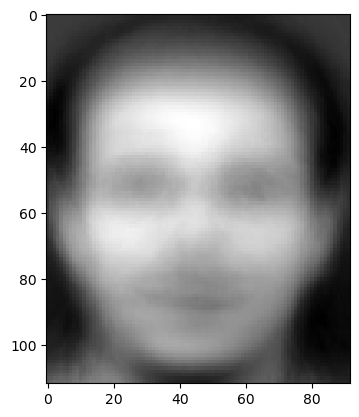

In [72]:
# Average Face
fig = plt.figure()
plt.imshow(featurewise_means.reshape(IMG_SHAPE), cmap = 'gray')
plt.show()

The Average Face!

In [74]:
# Computing the singular value decomposition of the covariance matrix:
U, S, VT = np.linalg.svd(X.T)

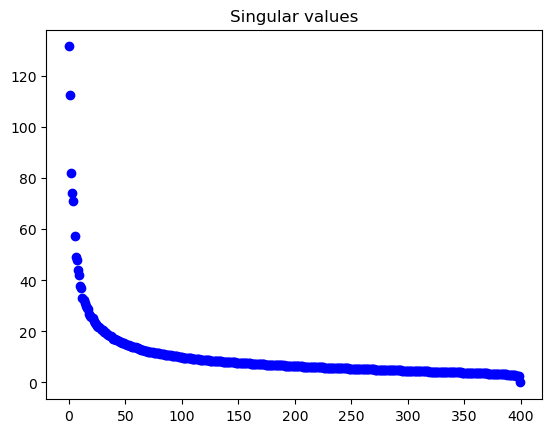

In [75]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

In [76]:
# The reduced dimensionality
k = 100

In [77]:
print(U.shape,S.shape,VT.shape)

(10304, 10304) (400,) (400, 400)


In [78]:
# Choosing the first k columns of VT
V_reduced = VT[0:k,:]

# Choosing the first k columns of U
U_reduced = U[:, 0:k]

# Choosing the k largest singular values
S_reduced = np.diag(S[0:k])

# Computing the k basis image vectors 
Z = U_reduced@S_reduced

In [79]:
Z.shape

(10304, 100)

In [80]:
print(U_reduced.shape,S_reduced.shape,V_reduced.shape)

(10304, 100) (100, 100) (100, 400)


In [81]:
Z[:,i].shape

(10304,)

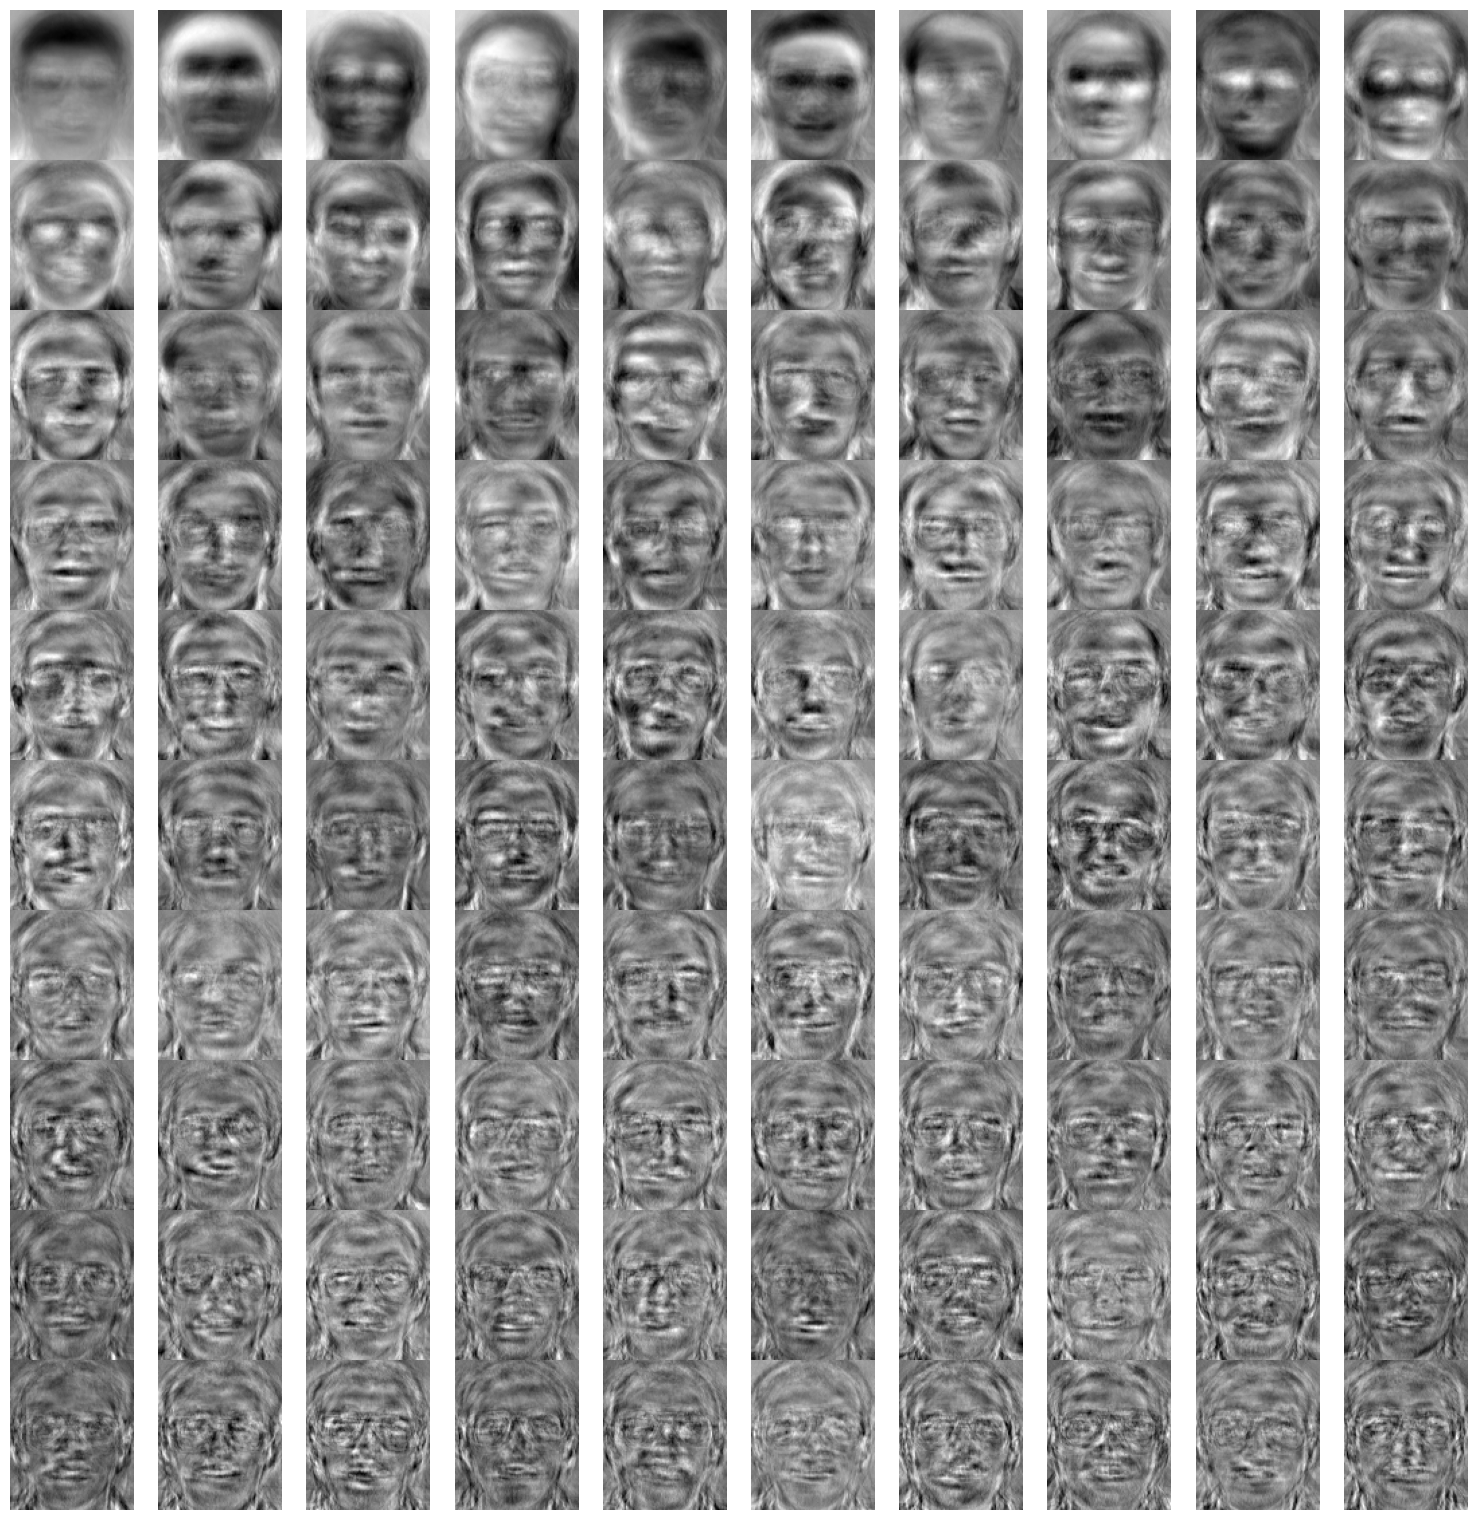

In [82]:
# Displaying the basis image vectors (called eigenfaces)
fig, axes = plt.subplots(10, 10, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(Z.shape[1])):
    ax.imshow(Z[:,i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
fig.tight_layout(pad = 0)

These are called eigenfaces!

In [84]:
Z.shape

(10304, 100)

In [85]:
V_reduced[:,0].shape

(100,)

In [86]:
A_0 = Z@V_reduced[:,0] + featurewise_means
A_0.shape

(10304,)

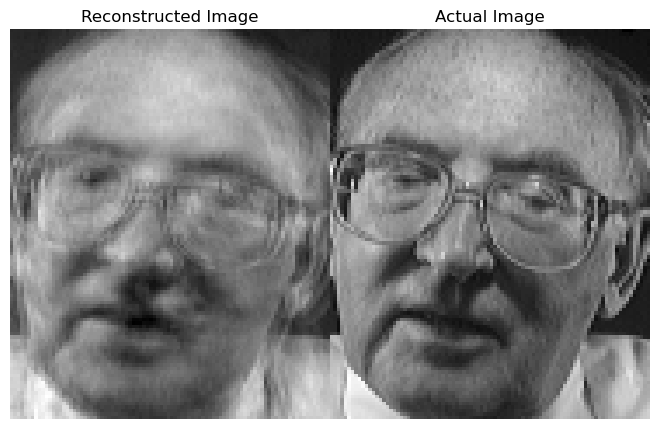

In [87]:
# Reconstructing the 0th image: 
# Displaying the images:
A_0 = A_0.reshape(IMG_SHAPE)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Reconstructed Image')
plt.imshow(A_0, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Actual Image')
plt.imshow(images[0].reshape(IMG_SHAPE), cmap='gray')
plt.tight_layout(pad = 0)
plt.show()

## 7. SVD for Spiked Data

A spiked matrix is a matrix of the form $A = \mathbf{u}\mathbf{v}^{\top} + \varepsilon B$, where $\varepsilon$ is a small number. We usually think of $\mathbf{u},\mathbf{v}$ as the signal, and $B$ as noise. SVD is very good at separating signal from noise in this situation, as we'll demonstrate in the next block of code.

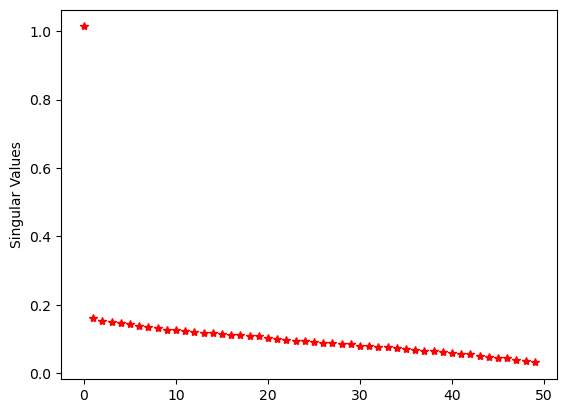

In [89]:
Noise_part = np.random.randn(100,50)
u1 = np.zeros([100,1])
u1[0] = 1
v1 = np.zeros([1,50])
v1[0,0] = 1
# print(v1)
epsilon = 0.01
Rank_one_part = np.dot(u1,v1)
A = Rank_one_part + epsilon*Noise_part
U,S,Vh = np.linalg.svd(A)
plt.plot(S,'r*')
plt.ylabel('Singular Values')
plt.show()

Thus, the singular values provide excellent evidence that $A$ is spiked. The first singular vectors will be an excellent approximation to the signal:

In [91]:
u1_tilde = np.round(np.reshape(U[:,0],(100,1)),2)
u1_tilde

array([[-0.99],
       [ 0.  ],
       [ 0.01],
       [-0.03],
       [-0.  ],
       [ 0.01],
       [ 0.  ],
       [-0.02],
       [-0.01],
       [ 0.  ],
       [-0.  ],
       [ 0.  ],
       [-0.02],
       [-0.01],
       [ 0.02],
       [ 0.02],
       [ 0.  ],
       [ 0.01],
       [ 0.  ],
       [ 0.02],
       [-0.  ],
       [ 0.01],
       [-0.02],
       [-0.  ],
       [ 0.02],
       [-0.03],
       [ 0.02],
       [-0.01],
       [-0.  ],
       [ 0.  ],
       [ 0.  ],
       [-0.  ],
       [ 0.01],
       [ 0.01],
       [-0.01],
       [-0.  ],
       [-0.01],
       [ 0.02],
       [ 0.02],
       [-0.  ],
       [ 0.01],
       [ 0.01],
       [ 0.  ],
       [ 0.01],
       [ 0.01],
       [-0.01],
       [-0.01],
       [ 0.01],
       [-0.  ],
       [ 0.  ],
       [-0.01],
       [ 0.  ],
       [ 0.  ],
       [ 0.01],
       [-0.01],
       [-0.  ],
       [ 0.  ],
       [-0.02],
       [-0.01],
       [ 0.01],
       [ 0.  ],
       [-0.01],
       [

We can expand the definition of spiked matrix to any matrix of the form: $A = (\text{low rank part}) + \varepsilon (\text{noise})$. 
Experiment with adding a rank 2 or 3 spike to $A$, and see what happens to the singular values.

## 3. Kernel PCA
Source: KPCA [tutorial 1](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html) and [tutorial 2](https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html#sphx-glr-auto-examples-applications-plot-digits-denoising-py).
                                                                                                                            

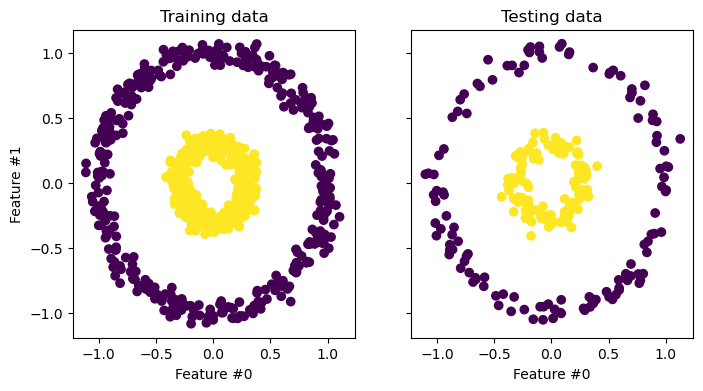

In [94]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [95]:
pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

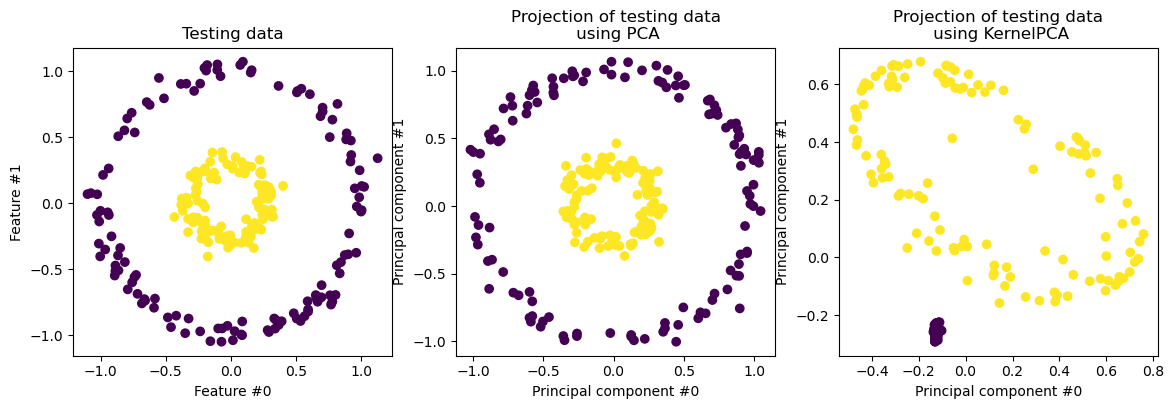

In [96]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

This is an example where Kernel PCA is able to find a projection of the data that linearly separates them while it is not the case with PCA. Inverting this projection is an approximation with Kernel PCA, while it is exact with PCA.

There are many more applications of SVD that are fundamental and significant in sciences.